# Viscosity Interpolation for Diesel (refined products

Some tests, examples of viscosity interpolation

As a rule, visoscity varies exponentially with temperature, so that's how we onterpolatie it

But something seemed wrong with some dat from LSFOs

Here's a check, using the KinematicViscosity Object from adios_db.computation

## Conclusion so far:

The fit to an exponential works well for crude oils -- which is what we determined way back when.

However -- it works really poorly for at least some ULSFOs -- maybe other distilled products as well.

## Solution?

First step is to check the residuals, and at least issue a warning.

Next step is to come up with a better interolatio method -- we could do piecwise (linear or exponential), but thatmight extrapolate really badly. That may not be SO bad for environmental conditions -- not a huge temp range --  but not great for labeling and the like.

I tried using only the outside two pooints -- not good.

Could a 3 parameter exponential fit work? IN theory, it should't -- viscosity should tend to zero at infinite temperature, but maybe it wold work OK locally -- at least it would exactly fit three points :-)

Hmm -- piecewise exponential, with the extrapolation using a the fit to the end points?




In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot  as plt
import nucos
import adios_db.scripting as ads
import adios_db.computation.physical_properties as pp

In [2]:
DATA_DIR = Path(r"/Users/chris.barker/Hazmat/GitLab/noaa-oil-data/data/oil/")
product_type = "Distillate Fuel Oil"
labels = {"Diesel"}

kvis_recs = []
dvis_recs = []

# Look through all the data for viscosity data
for oil, path in ads.get_all_records(DATA_DIR):
    # print("processing:", oil.metadata.name)
    if product_type is not None and oil.metadata.product_type != product_type:
        # print("not the right product type:", oil.metadata.product_type)
        continue
    if labels and (labels & set(oil.metadata.labels)):
        continue

    fresh = oil.sub_samples[0]

    kvis = fresh.physical_properties.kinematic_viscosities
    dvis = fresh.physical_properties.dynamic_viscosities

    if len(kvis) >= 3:
        kvis_recs.append(oil)
    if len(dvis) >=3:
        dvis_recs.append(oil)

print(f"found:{len(kvis_recs)} kvis and {len(dvis_recs)} divs records")






found:10 kvis and 18 divs records


AD02582: VLSFO O-1 (AMSA)
AD02583: VLSFO O-2 (AMSA)
AD02584: VLSFO O-3 (AMSA)
AD02585: VLSFO O-4 (AMSA)
AD02586: VLSFO O-5 (AMSA)
AD02587: VLSFO O-6 (AMSA)
AD02588: VLSFO O-7 (AMSA)
AD02589: VLSFO O-8 (AMSA)
AD02590: VLSFO O-9 (AMSA)
AD02591: VLSFO O-10 (AMSA)
AD02082: DIESEL FUEL OIL (CANADA)
AD02132: FUEL OIL NO.1 (JP-1)
AD02151: GASOLINE (LEADED)
AD02582: VLSFO O-1 (AMSA)
AD02583: VLSFO O-2 (AMSA)
AD02584: VLSFO O-3 (AMSA)
AD02585: VLSFO O-4 (AMSA)
AD02586: VLSFO O-5 (AMSA)
AD02587: VLSFO O-6 (AMSA)
AD02588: VLSFO O-7 (AMSA)
AD02589: VLSFO O-8 (AMSA)
AD02590: VLSFO O-9 (AMSA)
AD02591: VLSFO O-10 (AMSA)
AD02592: VLSFO IM-5 (IMAROS)
NO00119: MARINE GAS OIL 500 ppm S
NO00121: HEAVY DISTILLATE MARINE ECA 50
NO00122: ROTTERDAM DIESEL
NO00123: GAS OIL 10 ppm S


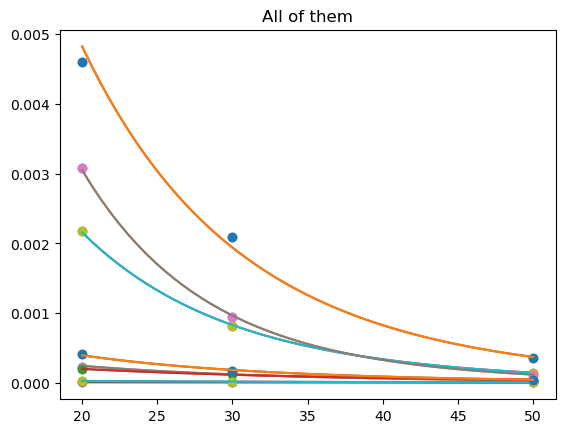

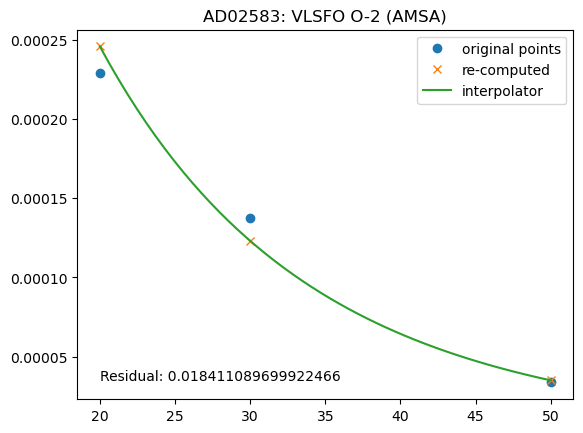

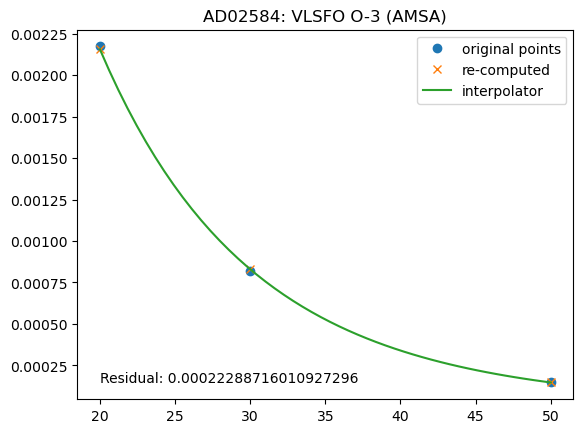

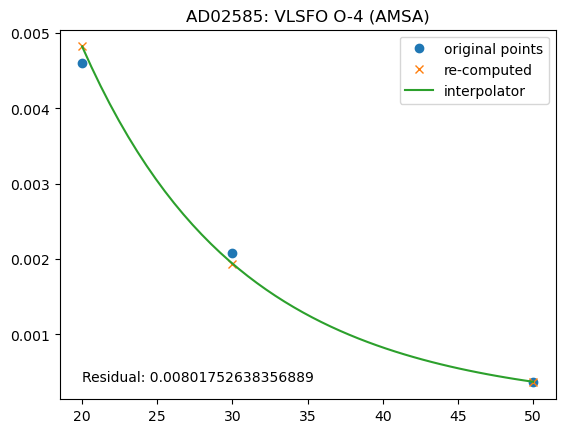

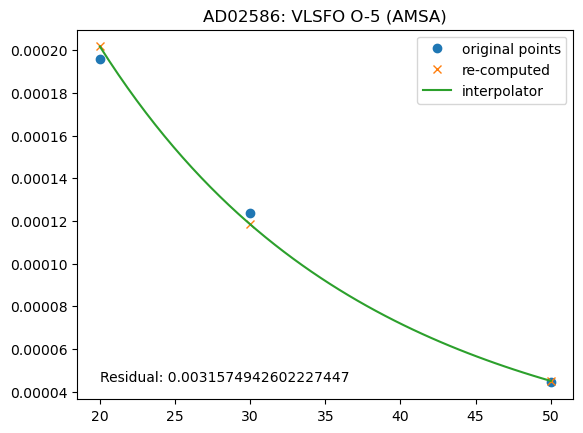

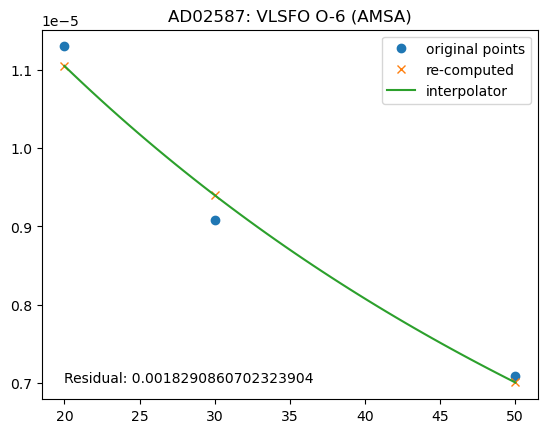

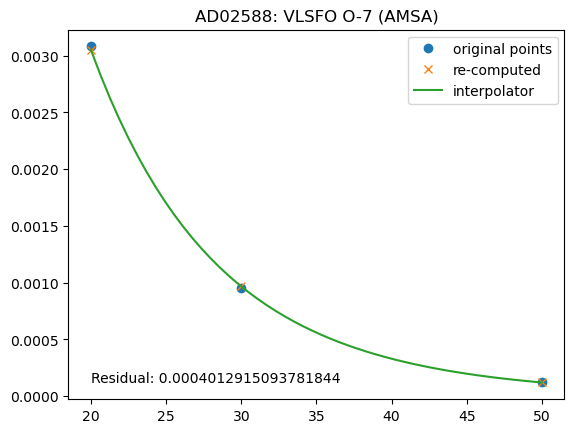

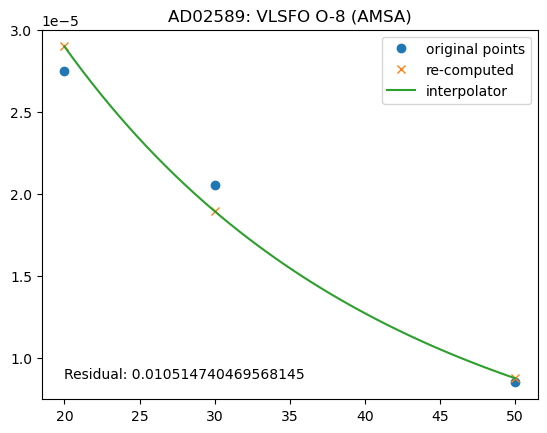

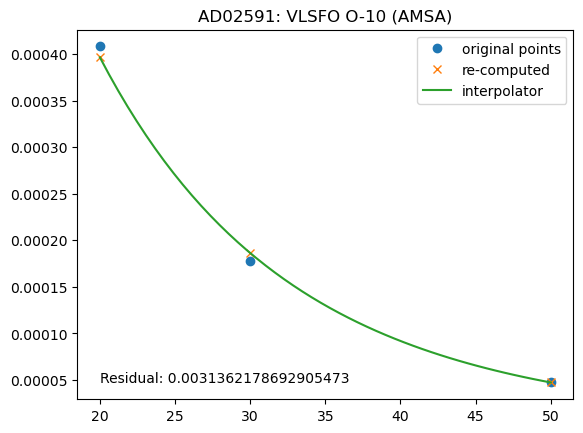

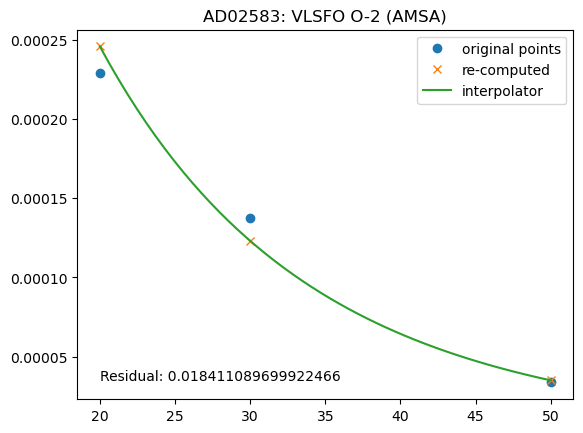

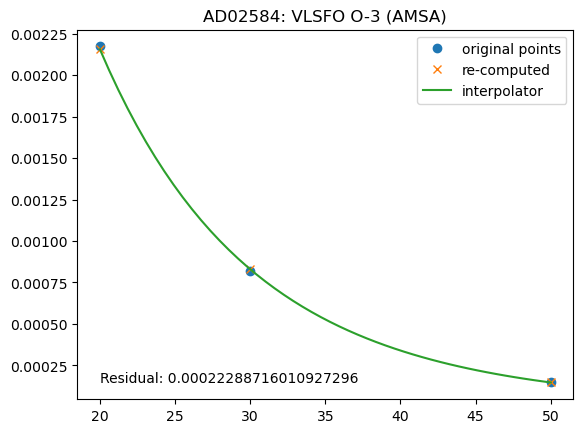

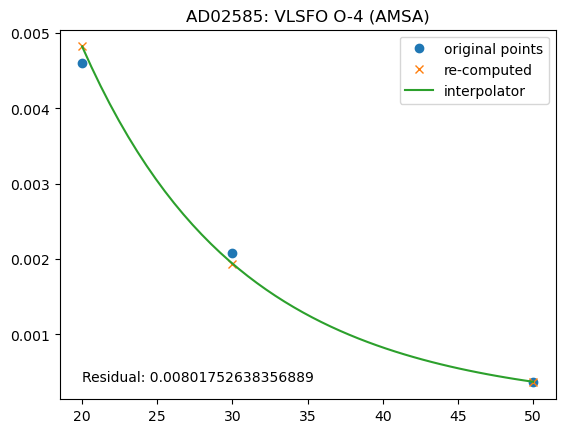

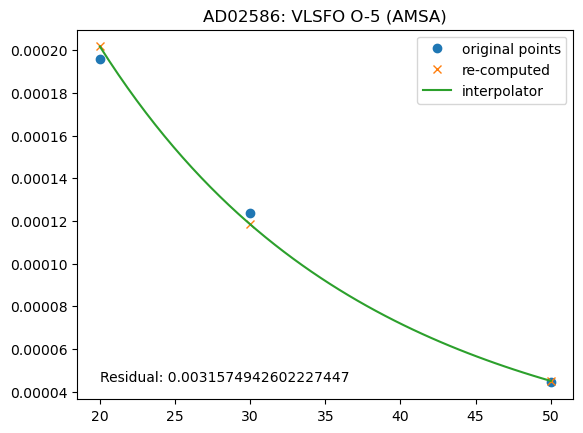

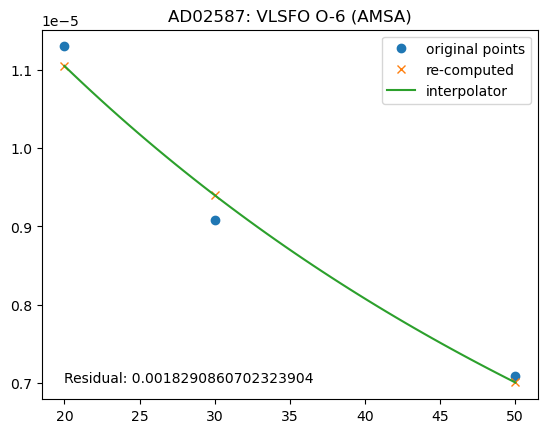

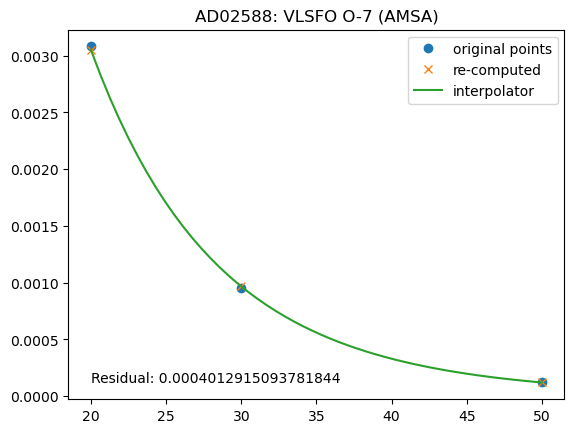

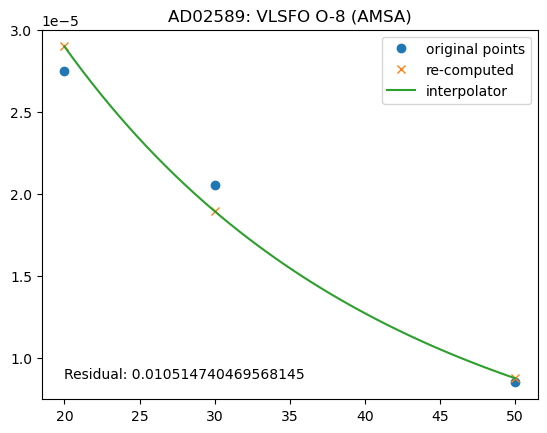

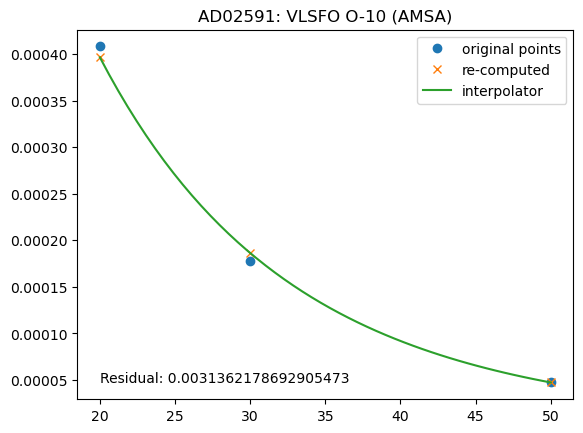

In [3]:
r_cutoff = 0.03

K_v2 = []
Visc_A = []
Residuals = []
oils_used = []
KVs = []

# set up the plot for the full set:
fig, total_ax = plt.subplots()
total_ax.set_title("All of them")

for oil in kvis_recs + dvis_recs:
    oil_name = oil.metadata.name
    oil_name = f"{oil.oil_id}: {oil_name}"
    print(oil_name)
    KV = pp.KinematicViscosity(oil)
    # remove obvious bad ones -- e.g. slope in the wrong direction
    if len(KV.residuals) == 1 and KV._k_v2 > 0 and KV.residuals[0] < r_cutoff:
        good = True
        oils_used.append(oil)
        K_v2.append(KV._k_v2)
        Visc_A.append(KV._visc_A)
        Residuals.append(KV.residuals[0])
    else:
        good = False
        continue

    
    visc = KV.kviscs
    temps = np.array(KV.temps)
    tempsC = nucos.convert('K', 'C', temps)
    visc2 = KV.at_temp(temps)

    temps3 = np.linspace(min(temps), max(temps))
    temps3C = nucos.convert('K', 'C', temps3)

    visc3 = KV.at_temp(temps3)
    fig, ax = plt.subplots()
    ax.set_title(oil_name)
    ax.plot(tempsC, visc, 'o')
    ax.plot(tempsC, visc2, 'x')
    ax.plot(temps3C, visc3)
    ax.legend(["original points", "re-computed", "interpolator"])
    ax.text(min(temps3C), min(visc3) , f"Residual: {KV.residuals[0]}")
    #KV_fit = pp.KinematicViscosity(visc[0])
    #fit_line = KV_fit.at_temp(temps3)
    #ax.plot(temps3C, fit_line)

#    break
    

    if good:
        total_ax.plot(tempsC, visc, 'o')
        total_ax.plot(temps3C, visc3)

K_v2 = np.array(K_v2)
Visc_A = np.array(Visc_A)
Residuals = np.array(Residuals)

In [1]:

print(KV.kviscs)
print(temps)
KV




NameError: name 'KV' is not defined

In [5]:
v2_avg = np.average(K_v2)
v2_std = np.std(K_v2)

print("Full dataset:")
print(f"Num_data points: {len(K_v2)} Average: {v2_avg} Std: {v2_std}")

pp.get_kinematic_viscosity_data(oil)



Full dataset:
Num_data points: 16 Average: 6200.526284739362 Std: 2641.7261294906875


[(6.002329624173734e-06, 275.15),
 (6.002400960384154e-06, 286.15),
 (2.1849612955716e-05, 323.15)]

In [6]:

KV2 = pp.KinematicViscosity([(6.002329624173734e-06, 275.15),
 (6.002400960384154e-06, 286.15),
 (2.1849612955716e-05, 323.15)])

KV2.at_temp(286.15)

KV2 = pp.KinematicViscosity(zip(KV.kviscs, KV.temps))

print(KV.at_temp(286.15))
print(KV2.at_temp(286.15))



7.381840607215709e-06
7.381840607215709e-06


Text(0.5, 1.0, 'Residuals')

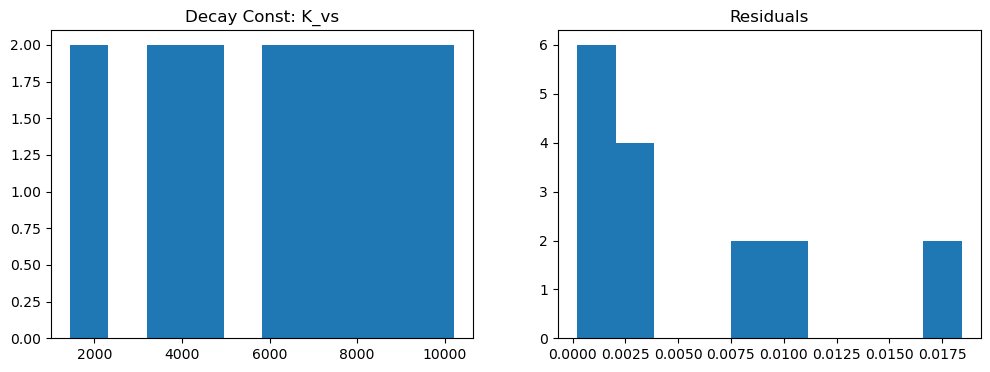

In [7]:
# plt.hist(Residuals, bins=5)
# v = plt.hist(Residuals, bins=np.linspace(0, 1, 5))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(K_v2)
ax1.set_title("Decay Const: K_vs")
ax2.hist(Residuals)
ax2.set_title("Residuals")




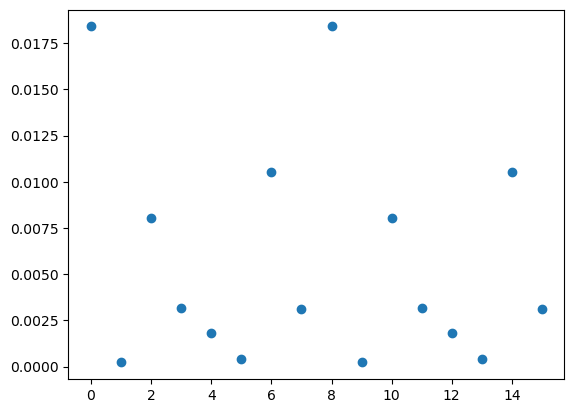

In [8]:
fig, ax = plt.subplots()

ax.plot(Residuals, 'o')


In [9]:
max(K_v2)

10216.335134800385